In [1]:
from aeronet.dataset import RandomDataset
from aeronet.dataset import BandCollection, parse_directory
from aeronet.dataset.transforms._vectorize import _vectorize, polygonize
from aeronet.dataset import BandSample
from aeronet.dataset.vector import FeatureCollection, Feature
from aeronet.backend.metrics import iou_score, f1_score

from keras.layers import Conv2D, Activation, concatenate, Input
from keras.models import Model, load_model
from keras import backend as K

import rasterio
import pandas as pd
import os
import numpy as np
from backend.utils import pad_x32, load_bc

from PIL import Image

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline


os.environ['CUDA_VISIBLE_DEVICES']='1'

Using TensorFlow backend.


## Data

In [2]:
data_dir = '../../data/california'
ventura = 'ventura_test'
santa_rosa = 'santa_rosa_test2'

checkpoints_dir = 'checkpoints_4'

channels_pre = ['RED', 'GRN', 'BLU']
channels_post = ['PRED', 'PGRN', 'PBLU']
output_labels = ['801']

ventura_bc =  load_bc(os.path.join(data_dir, ventura), ventura, channels_pre+channels_post, output_labels)
sr_bc =  load_bc(os.path.join(data_dir, santa_rosa), santa_rosa, channels_pre+channels_post, [])

## Evaluation

In [3]:
pre = ventura_bc.ordered(*channels_pre).numpy().transpose(1,2,0)
pre, pad = pad_x32(pre)
pre = pre[None,:,:,:]

post = ventura_bc.ordered(*channels_post).numpy().transpose(1,2,0)
post, pad = pad_x32(post)
post = post[None,:,:,:]

mask = ventura_bc.ordered(*output_labels).numpy().squeeze()

print(pre.shape, post.shape)

(1, 1344, 1056, 3) (1, 1344, 1056, 3)


In [4]:
experiments = {'TUNE_SYNTH_from_scratch_enc_freeze_sep256_{}_os': 'B-2',
               'TUNE_SYNTH_from_scratch_sep256_{}_os': 'B-2',
               'TUNE_SYNTH_imagenet_sep256_{}_os': 'D-2',
               'TUNE_SYNTH_imagenet_enc_freeze_sep256_r18_{}_os': 'D-1',
               'imagenet_{}_1_os': 'E', 
               'imagenet_{}_os': 'C', 
               'random_{}_os': 'A'}

fractions = [1,2,4,8,16]

In [5]:
results_iou = dict([(experiment_id, {}) for experiment, experiment_id in experiments.items()])
results_f1 = dict([(experiment_id, {}) for experiment, experiment_id in experiments.items()])
predictions = dict([(experiment_id, {}) for experiment, experiment_id in experiments.items()])

# a directory to save binary masks
save_dir = 'ventura_predictions'
os.makedirs(save_dir, exist_ok=True)

In [6]:
for experiment, experiment_id in tqdm(experiments.items()):
    for fraction in fractions:
        model_dir = os.path.join(checkpoints_dir, experiment.format(fraction), 'model.h5')
        model = load_model(model_dir, compile = False)

        pred = model.predict([pre, post]).squeeze()
        pred = (pred>0.5).astype(int)
        pred = pred[:-pad[0], :-pad[1]]
                           
        f1 = K.eval(f1_score(mask[None, :, :, None].astype(int), pred[None, :, :, None].astype(int)))      
        iou = K.eval(iou_score(mask[None, :, :, None].astype(int), pred[None, :, :, None].astype(int)))  

        
        results_f1[experiment_id][fraction] = f1
        results_iou[experiment_id][fraction] = iou
        predictions[experiment_id][fraction] = pred
        
        pred_mask = (pred*255).astype(np.uint8)
        img = Image.fromarray(pred_mask)

        img.save(f'{save_dir}/{experiment_id}_{fraction}.png')

In [10]:
df_iou = pd.DataFrame.from_dict(results_iou)
df_f1 = pd.DataFrame.from_dict(results_f1)

In [11]:
df_iou

,A,B-2,C,D-1,D-2,E
1,0.694626,0.706946,0.718242,0.715347,0.720131,0.724529
2,0.669165,0.681352,0.696339,0.707532,0.700495,0.609014
4,0.610919,0.625644,0.653768,0.684206,0.688118,0.543062
8,0.473231,0.487858,0.615047,0.655916,0.635512,0.202750
16,0.298622,0.324911,0.543320,0.581153,0.592226,0.296740


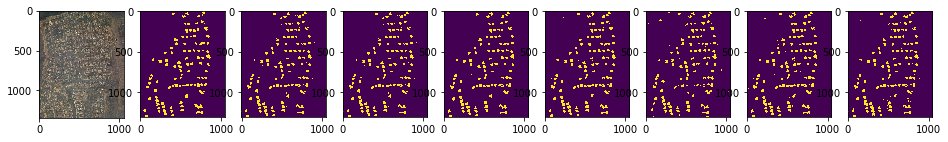

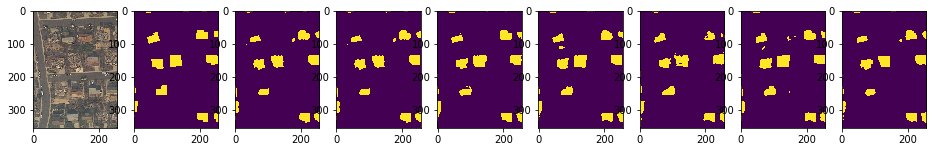

In [16]:
plt.figure(figsize = (16,10))
n=len(experiments)
cols =n+2
rows = 2
fraction = 2

plt.subplot(1,cols,1)
plt.imshow(post.squeeze().astype(np.uint8))

plt.subplot(1,cols,2)
plt.imshow(mask.squeeze())

for i, (experiment, experiment_id) in enumerate(experiments.items()):
    plt.subplot(1,cols,3+i)
    plt.imshow(predictions[experiment_id][fraction].squeeze())
    
x = 502
y = 512

h = 256
w = 356
plt.figure(figsize = (16,10))    
plt.subplot(2,cols,1)
plt.imshow(post.squeeze().astype(np.uint8)[x:x+w,y:y+h, :])

plt.subplot(2,cols,2)
plt.imshow(mask.squeeze()[x:x+w,y:y+h])

for i, (experiment, experiment_id) in enumerate(experiments.items()):
    plt.subplot(2,cols,3+i)
    plt.imshow(predictions[experiment_id][fraction].squeeze()[x:x+w,y:y+h])
    
# plt.tight_layout()